#Proyecto de Redes Neuronales para Análisis de Series Temporales

<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

---



**Integrantes:**

* Fiorela Lizárraga
* Frank Ygnacio
* Ricardo Llanos
* Yulian Cama


In [ ]:
# importamos librerías
import math
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from matplotlib import pylab as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [ ]:
# montamos drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# llamado de datos
data_train = pd.read_csv('/content/drive/MyDrive/Curso 7 - Redes Neuronales para Series de Tiempo/Train_base.txt')
data_test = pd.read_csv('/content/drive/MyDrive/Curso 7 - Redes Neuronales para Series de Tiempo/Test_base.txt')

####Análisis

In [ ]:
#Visualizamos los campos del registro
data_train.head(3)

,ID_Registro,FechaRegistro,HoraRegistro,Consumo_Energia_Global_kw,Consumo_Energia_Reactiva_kw,Voltaje_vol,Intensidad_global_ampere,Consumo_Energia_Area_1_administrativo_watt_hora,Consumo_Energia_Area_2_calidad_watt_hora,Consumo_Energia_Area_3_productivo_watt_hora
0,0,2015-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,1,2015-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2,2015-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0


In [ ]:
#Verificamos las estadísticas de tabla
data_train.describe()

,ID_Registro,Consumo_Energia_Global_kw,Consumo_Energia_Reactiva_kw,Voltaje_vol,Intensidad_global_ampere,Consumo_Energia_Area_1_administrativo_watt_hora,Consumo_Energia_Area_2_calidad_watt_hora,Consumo_Energia_Area_3_productivo_watt_hora
count,1.954519e+06,1.954519e+06,1.954519e+06,1.954519e+06,1.954519e+06,1.954519e+06,1.954519e+06,1.954519e+06
mean,9.832141e+05,1.088841e+00,1.236922e-01,2.408098e+02,4.617369e+00,1.121869e+00,1.305146e+00,6.437946e+00
std,5.679441e+05,1.061363e+00,1.126619e-01,3.224924e+00,4.460546e+00,6.160865e+00,5.850815e+00,8.427228e+00
min,0.000000e+00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.925625e+05,3.060000e-01,4.800000e-02,2.389700e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.812490e+05,5.920000e-01,1.000000e-01,2.409800e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.474234e+06,1.524000e+00,1.940000e-01,2.428500e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.975259e+06,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


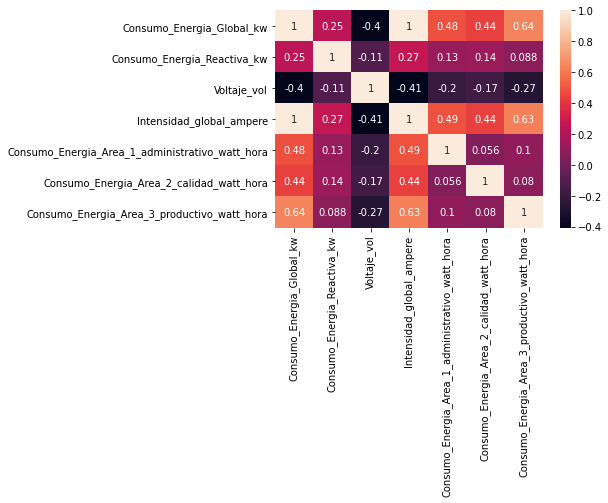

In [ ]:
#Generamos la matriz de correlación de variables y notamos una muy alta correlación entre la variable objetivo "Consumo_energia_global_kw" e "Intensidad_global_ampere"
correlation_mat = data_train.iloc[:,3:].corr()
sns.heatmap(correlation_mat, annot = True, )
plt.show()

**Variables de mayor correlación con Consumo_energia_global_kw:**

    -Intensidad global ampere (1)
    -Consumo_Energia_Area_1_administrativo_watt_hora (0.48)
    -Consumo_Energia_Area_2_calidad_watt_hora (0.44)
    -Consumo_Energia_Area_3_productivo_watt_hora (0.64)

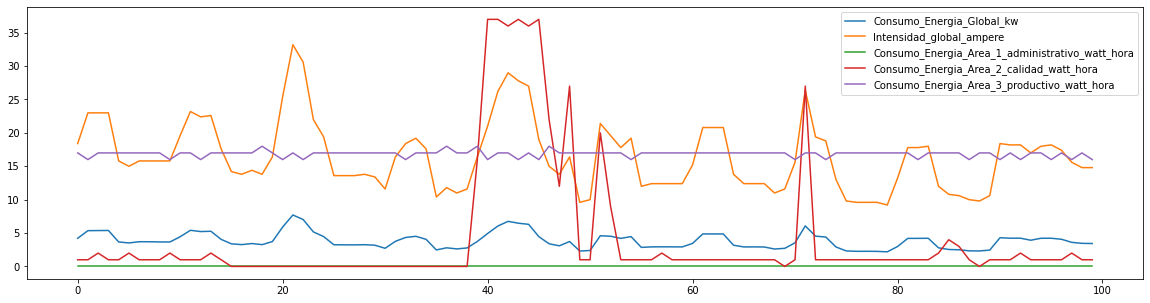

In [ ]:
#Ploteamos las variables con un indice de correlación mayor a 0.4
data_train.iloc[:100,([3,6,7,8,9])].plot(figsize=(20,5))

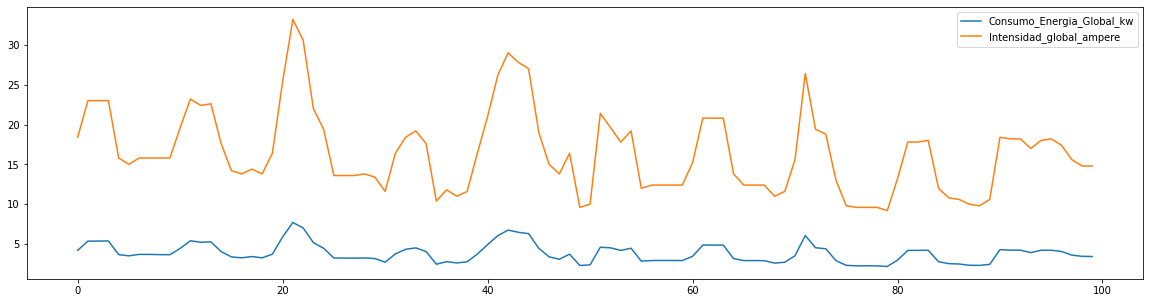

In [ ]:
#Las gráficas de la variable objetivo junto con Intensidad_global_ampere siguen una misma tendencia
data_train.loc[:,('Consumo_Energia_Global_kw','Intensidad_global_ampere')][:100].plot(figsize=(20,5))

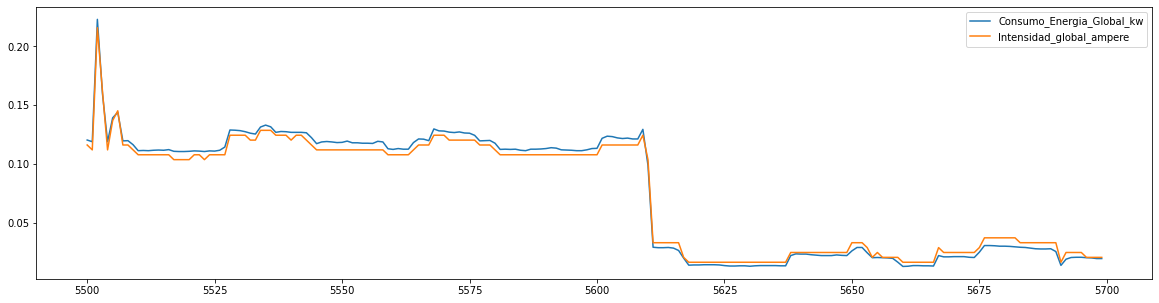

In [ ]:
#Escalamos la información relacionada y confirmamos que es una variable de relación directa muy aproximada
scaler = MinMaxScaler()
valuesPoints = data_train.loc[:,('Consumo_Energia_Global_kw','Intensidad_global_ampere')]
valuesPoints[['Consumo_Energia_Global_kw','Intensidad_global_ampere']] = scaler.fit_transform(valuesPoints[['Consumo_Energia_Global_kw','Intensidad_global_ampere']])
valuesPoints[5500:5700].plot(figsize=(20,5))

In [ ]:
# seleccionamos elementos princ. del dataset
main_dataset = data_train.iloc[:,3:]
main_dataset = main_dataset.iloc[:,[0,3]]

In [ ]:
main_dataset

,Consumo_Energia_Global_kw,Intensidad_global_ampere
0,4.216,18.4
1,5.360,23.0
2,5.374,23.0
3,5.388,23.0
4,3.666,15.8
...,...,...
1954514,0.582,2.6
1954515,0.576,2.6
1954516,0.576,2.6
1954517,0.574,2.6


In [ ]:
# puntos de dataset
valuesPoints = main_dataset.values
valuesPoints = valuesPoints .astype('float32')

In [ ]:
# escalamiento 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(valuesPoints)

In [ ]:
print(":::::> DESACTIVANDO EL LAGG | REDEFINIENDO 'reframed' df <:::::")
print("****"*20)
reframed = pd.DataFrame(scaled)
reframed.columns = main_dataset.columns
reframed

:::::> DESACTIVANDO EL LAGG | REDEFINIENDO 'reframed' df <:::::
********************************************************************************


,Consumo_Energia_Global_kw,Intensidad_global_ampere
0,0.374796,0.377593
1,0.478363,0.473029
2,0.479631,0.473029
3,0.480898,0.473029
4,0.325005,0.323651
...,...,...
1954514,0.045808,0.049793
1954515,0.045265,0.049793
1954516,0.045265,0.049793
1954517,0.045084,0.049793


In [ ]:
# definiendo la variable útil para el modelamiento
sampledDataset = reframed

In [ ]:
#division train y test
values = sampledDataset.values
train_size = int(len(values) * 0.75)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]
print(len(train), len(test))

1465889 488630


In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1465889, 1, 1) (1465889,) (488630, 1, 1) (488630,)


#### Red 1

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)

In [ ]:
# fit de la red LSTM
history = model1.fit(
    train_X, train_y, 
    epochs=200, batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, shuffle=False
    )

Epoch 1/200
1466/1466 - 5s - loss: 0.0053 - val_loss: 1.0629e-04
Epoch 2/200
1466/1466 - 4s - loss: 3.6040e-05 - val_loss: 2.2081e-05
Epoch 3/200
1466/1466 - 4s - loss: 2.3147e-05 - val_loss: 1.8902e-05
Epoch 4/200
1466/1466 - 4s - loss: 2.0242e-05 - val_loss: 1.8040e-05
Epoch 5/200
1466/1466 - 4s - loss: 1.9480e-05 - val_loss: 1.7826e-05
Epoch 6/200
1466/1466 - 4s - loss: 1.9405e-05 - val_loss: 1.7877e-05
Epoch 7/200
1466/1466 - 4s - loss: 1.9295e-05 - val_loss: 1.7915e-05
Epoch 8/200
1466/1466 - 4s - loss: 1.9152e-05 - val_loss: 1.7881e-05
Epoch 9/200
1466/1466 - 4s - loss: 1.9017e-05 - val_loss: 1.7840e-05
Epoch 10/200
1466/1466 - 4s - loss: 1.8899e-05 - val_loss: 1.7807e-05
Epoch 11/200
1466/1466 - 4s - loss: 1.8797e-05 - val_loss: 1.7782e-05
Epoch 12/200
1466/1466 - 4s - loss: 1.8708e-05 - val_loss: 1.7762e-05
Epoch 13/200
1466/1466 - 4s - loss: 1.8630e-05 - val_loss: 1.7746e-05
Epoch 14/200
1466/1466 - 4s - loss: 1.8563e-05 - val_loss: 1.7731e-05
Epoch 15/200
1466/1466 - 4s - los

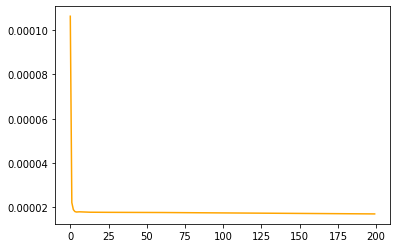

In [ ]:
plt.plot(history.history['val_loss'], label='test', color='orange') #ValLost

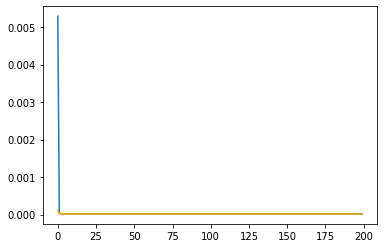

In [ ]:
plt.plot(history.history['loss'], label='train') #Lost

In [ ]:
# make a prediction
yhat = model1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
# invert scaling for forecast
obj = scaler.fit(test_X)
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = obj.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.004


### Predicción Kaggle

In [ ]:
dataTesting = data_test.iloc[:,3:].iloc[:,[2]].values
dataTesting = scaler.fit_transform(dataTesting)
dataTesting = dataTesting.reshape((dataTesting.shape[0], 1, dataTesting.shape[1]))

In [ ]:
predictionsKaggle = model1.predict(dataTesting)

In [ ]:
dataTesting = dataTesting.reshape((dataTesting.shape[0], dataTesting.shape[2]))

In [ ]:
scalerK = MinMaxScaler()
objKaggle = scalerK.fit(data_train.iloc[:,3].values.reshape(-1, 1))

In [ ]:
results = scalerK.inverse_transform(predictionsKaggle.reshape(-1,1))

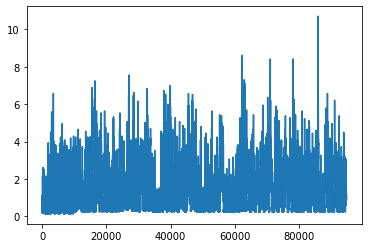

In [ ]:
plt.plot(results)

In [ ]:
resultsDf = pd.DataFrame(data_test["ID_Registro"])
resultsDf['Consumo_Energia_Global_kw'] = results

In [ ]:
resultsDf

,ID_Registro,Consumo_Energia_Global_kw
0,1975259,0.613641
1,1975260,0.613641
2,1975261,0.564691
3,1975262,0.515800
4,1975263,0.515800
...,...,...
94757,2075254,0.957818
94758,2075255,0.957818
94759,2075256,0.908495
94760,2075257,0.908495


In [ ]:
resultsDf.to_csv('kaggle_results.csv', index=False) 

### Referencias 

1. https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

2. https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/ 

3. https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

4. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

